In [105]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import pickle
  # 데이터 처리
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize
  # 선형대수, 행렬 연산 등
import math
from typing import *
import requests
import json, traceback
from bs4 import BeautifulSoup as soup
  # 크롤링할 때 url을 통해 웹페이지 html 문서 (문자열) 요청
!pip install pykrx
from pykrx import stock
!pip install investpy
import investpy
  # 금융 데이터
import re
  # 정규표현식
import time
from datetime import datetime
from dateutil.relativedelta import relativedelta
  # 날짜형 타입 처리
import matplotlib.pyplot as plt
import seaborn as sns

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [106]:
# 한글 폰트 사용을 위해서 세팅

from matplotlib import font_manager, rc
font_path = r"/content/drive/MyDrive/FindAlpha_RiskyAsset1/archive/korean.ttf"
  # 오류가 발생한다면, 경로를 "/content/drive/FindAlpha_RiskyAsset1/archive/korean.ttf"로 설정
  # 혹은 로컬 폰트 경로인 "C:\\WINDOWS\FONTS\malgun.ttf"로 설정
font = font_manager.FontProperties(fname = font_path).get_name()
rc("font", family = font)

### [주식 포트폴리오 구성] ScreeningFinancialData 부모 클래스

1. PBR의 분위수별 GPA의 평균값 계산하여 자산배분
* PBR을 5분위 수로 나눈 후 분위수별 GPA의 평균(Gross Profit / Asset), pd.qcut(labels = range(1, 6, 1))


2. 이익수익률(기업의 수익* / 기업의 가치)과 투하자본수익률(ROE, 기업의 수익 / 투자한 자본)을 기준으로 자산배분
  
  PER과 ROE와 각 비교해볼 것

  *) EBIT(이자 및 법인세 차감 전 이익)

* 이익수익률 
  
  = EBIT / 기업가치 
  
  = EBIT / (시가총액 + 순차입금) 
  
  = (당기손익 + 법인세 + 이자비용) / (시가총액 + 총부채 - 여유자금) 

  = (당기손익 + 법인세 + 이자비용) / (시가총액 + 총부채 - (현금 - Max(0, 유동부채 - 유동자산 + 현금))

* 전체 종목과 선택된 20위의 종목의 산점도 시각화
* 출처 : 파이썬을 이용한 퀀트 투자 포트폴리오 만들기

In [139]:
class ScreeningFinancialData():
  
  def __init__(self, financial_data = None,
               sector = None, stock_price = None, value_ratio = None,
               financial_data_screening = None):
    
    self.financial_data = financial_data
    self.sector = sector
    self.stock_price = stock_price
    self.value_ratio = value_ratio  
    self.financial_data_screening = financial_data_screening


# ImportPickleData()
# 데이터를 불러와서 분석 목적에 맞게 처리(전처리라기보다는 정리에 가까움)하는 함수
  def ImportPickleData(self):  

  # (객체, 파일)로 저장(dump) 후 파일 로딩(load) -> 판다스 pickle 데이터 로드하는 메서드 활용
    financial_sheet = pd.read_pickle("/content/drive/MyDrive/archive/data_find_alpha/kor_fs.pkl")
    sector = pd.read_pickle("/content/drive/MyDrive/archive/data_find_alpha/kor_sector.pkl")
    stock_price = pd.read_pickle("/content/drive/MyDrive/archive/data_find_alpha/kor_price.pkl")
    maket_cap = pd.read_pickle("/content/drive/MyDrive/archive/data_find_alpha/kor_ticker.pkl")
    value_ratio = pd.read_pickle(("/content/drive/MyDrive/archive/data_find_alpha/kor_value.pkl"))
      # with open("/content/drive/MyDrive/archive/data_find_alpha/kor_fs.pkl", "wb") as fw: pickle.dump(financial_sheet, fw)
      # with open("/content/drive/MyDrive/archive/data_find_alpha/kor_fs.pkl", "rb") as fr: pickle.load(fr)
      
    self.sector = sector
    self.stock_price = stock_price
    self.value_ratio = value_ratio

  # 재무 데이터를 종목코드, 계정, 기준일 순의 컬럼 기준으로 오름차순 정렬
    financial_sheet = financial_sheet.sort_values([
        "종목코드",
        "계정",
        "기준일"])
    
  # 4개 분기의 재무 지표 (이동)합
    financial_sheet["ttm"] = financial_sheet.groupby(
        ["종목코드", "계정"], as_index = False)["값"].rolling(
        window = 4, min_periods = 4).sum()["값"]
      # 값 컬럼에 대하여 계산할 창 window의 크기(4)를 최소 크기(기간, 4)로 합 계산 수행하여 
      # ttm(trailing twelve month, 최근 월 대비 과거 12개월의 수치) 컬럼 생성
  
  # 재무상태표의 4개의 계정과목은 평균을 구하고, 나머지 지표는 rolling sum()
    financial_sheet_sorted = financial_sheet.copy()
    financial_sheet_sorted["ttm"] = np.where(
        financial_sheet_sorted["계정"].isin(["부채", "유동부채", "유동자산", "비유동자산"]),
        financial_sheet_sorted["ttm"] / 4,
        financial_sheet_sorted["ttm"]
    )
    financial_sheet_sorted = financial_sheet_sorted.groupby(["종목코드", "계정"]).tail(1)
    financial_sheet_sorted = financial_sheet_sorted.pivot(
        index = "종목코드", columns = "계정", values = "ttm"
    )
      # 행 위치에 들어갈 열 "종목코드"
      # 열 위치에 들어갈 열 "계정"
      # 데이터(값)으로 사용할 열 "ttm"
      # 데이터프레임 피벗
    financial_data = maket_cap[["종목코드", "종목명", "시가총액"]].merge(
        financial_sheet_sorted,
        how = "left",
        on = "종목코드"
    )
      # 시가총액 데이터와 재무데이터를 시가총액 데이터, "종목코드"를 기준으로 병합
    financial_data["시가총액"] = financial_data["시가총액"] / 100000000
      # 시가총액은 원 단위이며, 재무제표는 억 단위이므로 시가총액 단위 변환
    self.financial_data = financial_data

    # return financial_sheet_sorted, sector, stock_price
    return self.financial_data


# EarningYield()
# 이익수익률을 계산하는 함수
  def EarningYield(self):  
    # 이익수익률을 계산하는 함수

  # 매출액 | 당기손익 | 법인세비용 | 이자비용 | 현금 및 현금성 자산 | 부채 | 유동부채 | 유동자산 | 비유동자산 | 감가상각비
    
    def earning_yield(dataframe):
      법인세및이자_차감전_영업이익 = dataframe["당기순이익"] + dataframe["법인세비용"] + dataframe["이자비용"]
      시가총액 = dataframe["시가총액"]
      부채 = dataframe["부채"]
      순운전자본 = dataframe["유동부채"] - dataframe["유동자산"] + dataframe["현금및현금성자산"]
        # EBIT, Cap, Debt, Net Working Capital(Excess cash)를 pd.Series화
      순운전자본[순운전자본 < 0] = 0
        # 음수인 NWC를 0으로 변환
      순운전자본변동분 = dataframe["현금및현금성자산"] - 순운전자본
      기업가치 = 시가총액 + 부채 - 순운전자본변동분
        # 영업활동에 투입된 자기자본가치 + 영업활동에 투입된 타인자본가치 - 여유자금

      이익수익률 = 법인세및이자_차감전_영업이익 / 기업가치
      return 이익수익률

    self.financial_data["이익수익률"] = earning_yield(self.financial_data)
  

# ReturnOnCapital()
# 투하자본수익률(투자한 자본 대비 어느정도의 영업이익을 냈는지 보여주는 밸류 지표)를 계산하는 함수
  def ReturnOnCapital(self):
    
    def ROC(dataframe):
      법인세및이자_차감전_영업이익 = dataframe["당기순이익"] + dataframe["법인세비용"] + dataframe["이자비용"]
      투하자본 = (dataframe["유동자산"] - dataframe["유동부채"]) + (dataframe["비유동자산"] - dataframe["감가상각비"])

      투하자본수익률 = 법인세및이자_차감전_영업이익 / 투하자본
      return 투하자본수익률

    self.financial_data["투하자본수익률"] = ROC(self.financial_data)
    # 시행착오
    # self.financial_data["투하자본수익률"] = self.financial_data.apply(ROC)


# ScreeningTicker()
# 상장주식종목 스크리닝하는 함수
  def ScreeningTicker(self):
    
  # 이익수익률과 투하자본수익률이 높은 순으로 순위 설정(상위 20위까지 선정)
    financial_data_rank = (self.financial_data["이익수익률"].rank(ascending = False, axis = 0) + 
                           self.financial_data["투하자본수익률"].rank(ascending = False, axis = 0)).rank(axis = 0)
    financial_data_screening = self.financial_data.loc[
        financial_data_rank <= 20,
        ["종목코드", "종목명", "이익수익률", "투하자본수익률"]
    ].round(4)
    self.financial_data["종목선택여부"] = np.where(
        financial_data_rank <= 20, "선택", "제외")
      # [ValueError] Length of values (2513) does not match length of index (20)
    self.financial_data_screening = financial_data_screening

    # return self.financial_data
    return financial_data_screening
      # 종목 스크리닝 전 업종을 반영해볼 방법은 없는지 고민해볼 것
      # 여러 팩터의 순위를 구한 후 Z점수(표준화)한 값을 비교하는 방법을 활용해볼 것

  def VisualizeScatterPlot(self):
    sns.scatterplot(
        data = self.financial_data,
        x = "이익수익률",
        y = "투하자본수익률",
        hue = "종목선택여부",
        style = "종목선택여부" 
    )
    plt.xlim(0, 1)
    plt.ylim(0, 1)
      # plt.scatter(x = self.financial_data["이익수익률"], y = self.financial_data[], cmap = "Spectral")

In [140]:
DA = ScreeningFinancialData()

In [141]:
findata = DA.ImportPickleData()

In [142]:
pd.set_option("display.min_rows", 30)
# pd.options.display.max_rows = 30

In [143]:
findata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2513 entries, 0 to 2512
Columns: 550 entries, 종목코드 to 후순위사채의상환
dtypes: float64(548), object(2)
memory usage: 10.6+ MB


In [144]:
index: int = 0

for index in range(0, 551, 50):
  findata.iloc[:, index:index + 50].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2513 entries, 0 to 2512
Data columns (total 50 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   종목코드                     2513 non-null   object 
 1   종목명                      2513 non-null   object 
 2   시가총액                     2513 non-null   float64
 3   (재무활동으로 인한 현금유출액)        1 non-null      float64
 4   (재무활동으로인한현금유출액)          2251 non-null   float64
 5   (투자활동으로 인한 현금유출액)        1 non-null      float64
 6   (투자활동으로인한현금유출액)          2264 non-null   float64
 7   (현금 유입이 없는 수익 등 차감)      1 non-null      float64
 8   (현금유입이없는수익등차감)           2261 non-null   float64
 9   *CMA(어음관리계좌)운용자산명목금액     0 non-null      float64
 10  *감가상각누계액                 0 non-null      float64
 11  *기타예수유가증권                7 non-null      float64
 12  *대손충당금                   54 non-null     float64
 13  *대출채권명목금액                54 non-null     float64
 14  *리스자산명목금액               

In [145]:
DA.EarningYield()

In [146]:
DA.ReturnOnCapital()

In [147]:
DA.ScreeningTicker()

,종목코드,종목명,이익수익률,투하자본수익률
154,002630,오리엔트바이오,0.8290,1.0756
264,004720,팜젠사이언스,0.6596,0.9039
389,007700,F&F홀딩스,1.7342,1.0837
490,011200,HMM,1.0396,0.9782
505,011780,금호석유,0.7298,0.8087
754,030960,양지사,0.7661,0.9041
832,035510,신세계 I&C,0.7115,0.7154
1130,058430,포스코스틸리온,0.6564,0.7387
1383,084650,랩지노믹스,1.1944,1.3383
1501,095270,웨이브일렉트로,2.6238,1.5536


/usr/local/lib/python3.9/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 51061 (\N{HANGUL SYLLABLE IG}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 47456 (\N{HANGUL SYLLABLE RYUL}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 53804 (\N{HANGUL SYLLABLE TU}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 54616 (\N{HANGUL SYLLABLE HA}) missing from current font.
  func(*args, **kwarg

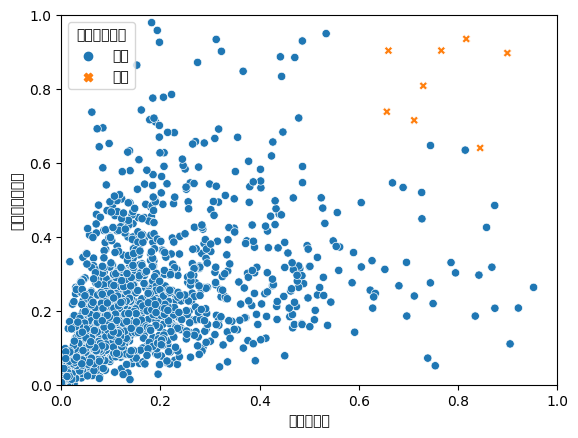

In [148]:
DA.VisualizeScatterPlot()

### [자산배분 비중 가중치] MinimumVolatilityPortfolio 자식 클래스
* 포트폴리오 최적화 이론(3)
* 보험금융연구 제31권 제3호 (2020. 8) pp. 171-210 : 최적 포트폴리오의 개선:새로운 상관행렬 개선방법


In [199]:
class MinimumVolatilityPortfolio(ScreeningFinancialData):
  
# 부모 클래스의 메서드를 호출하는 super()와 자식클래스의 생성자 
  def __init__(self, financial_data = None, sector = None, stock_price = None, value_ratio = None, financial_data_screening = None, 
               portfolio_data = None, covariance_matrix = None,):
    super().__init__(
        financial_data, sector, stock_price, value_ratio, financial_data_screening)
    self.portfolio_data = portfolio_data
    self.covariance_matrix = covariance_matrix


  def HandlingData(self):
  
  # 일일 수익률 평균에 연간 거래일수(252일)를 곱하여 연 수익률 계산 
    returns = self.stock_price["종가"].pct_change().mean() * 252
    returns_data = pd.DataFrame()
    returns_data["연간 수익률"] = returns
    returns_data["종목코드"] = self.stock_price["종목코드"]

    self.portfolio_data = self.financial_data_screening.merge(
        returns_data, how = "left", on = "종목코드")
    # self.portfolio_data = portfolio_data.merge(self.value_ratio, how = "left", on = "종목코드")
    
    return self.portfolio_data

    
  def MinimumVolatilityObject(self):
    
    covariance_matrix = self.portfolio_data.cov()
      # 공분산 행렬
    variance = self.portfolio_data.T @ covariance_matrix @ self.portfolio_data
    sigma = variance ** 0.5
    
    return sigma

  
 

In [200]:
Weight = MinimumVolatilityPortfolio()

In [208]:
Weight.ImportPickleData()
Weight.EarningYield()
Weight.ReturnOnCapital()
pf = Weight.ScreeningTicker()

In [209]:
pf

,종목코드,종목명,이익수익률,투하자본수익률
154,002630,오리엔트바이오,0.8290,1.0756
264,004720,팜젠사이언스,0.6596,0.9039
389,007700,F&F홀딩스,1.7342,1.0837
490,011200,HMM,1.0396,0.9782
505,011780,금호석유,0.7298,0.8087
754,030960,양지사,0.7661,0.9041
832,035510,신세계 I&C,0.7115,0.7154
1130,058430,포스코스틸리온,0.6564,0.7387
1383,084650,랩지노믹스,1.1944,1.3383
1501,095270,웨이브일렉트로,2.6238,1.5536


In [217]:
편입종목코드 = pf.iloc[:, 0]
편입종목명 = pf.iloc[:, 1]

In [210]:
pf_data = Weight.HandlingData()

In [211]:
pf_data.isnull().sum()
  # NaN Error

종목코드           0
종목명            0
이익수익률          0
투하자본수익률        0
연간 수익률     21722
dtype: int64

In [ ]:
Weight.MinimumVolatilityObject()
  # ValueError: matrices are not aligned

### 유가증권 포트폴리오 성과측정지표별 평가
* 퀀트 대디 퀀트 트레이딩 블로그: https://blog.naver.com/PostView.naver?blogId=stochastic73&logNo=222131457180&parentCategoryNo=&categoryNo=18&viewDate=&isShowPopularPosts=true&from=search
* $ skew_{return} = \frac{T}{(T-1)(T-2)} \Sigma_{i=1}^{T} {\frac{r_i - \bar{r}}{S_{return}}} $ 
  
  분포가 한쪽으로 쏠린 정도

* $ kurt_{return} = \frac{T(T+1)}{(T-1)(T-2)(T-3)} $ 
  
  분포의 꼬리에 관한 것으로 왼쪽과 오른쪽 꼬리 극값의 차이(저차원 데이터의 이상치 찾을 때 활용)

* CoSkew_return, benchmark
* CoKurt_return, benchmark

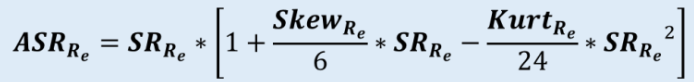

In [127]:
class EvaluationPortfolio():

  def __init__(self, portfolio_data):
    self.portfolio_data = portfolio_data


# 전략의 테일리스크가 뭘까 : 왜도, 첨도, 공왜도, 공첨도에 대한 이해 必
# 벤치마크 대비 전략의 수익률 분포가 얼마나 왜도, 첨도를 가지고 있는지 알고 싶을 때 사용하는 지표
  def adjusted_sharpe_ratio(self, ticker: List):

    수익률 = 
      # 최소분산 포트폴리오 클래스의 에러로 데이터를 새로 불러와야 함
    벤치마크 = 
      # 벤치마크를 어떤 지수로 설정해야 하는지, 데이터 새로 불러와야 함 
  
  # 왜도
    skewness = np.skewness(수익률 - 벤치마크)
  # 첨도
    kurtosis = np.kurtosis(수익률 - 벤치마크)
    sharpe_ratio = np.average(수익률 - 벤치마크) / np.std(수익률 - 벤치마크)
  # 조정된 샤프비율(정규분포를 따르지 않는 왜도와 첨도를 반영하는 성과지표)

  
  def sortino_ratio(self):

In [218]:
편입종목코드, 편입종목명

(154     002630
 264     004720
 389     007700
 490     011200
 505     011780
 754     030960
 832     035510
 1130    058430
 1383    084650
 1501    095270
 1514    096530
 1582    104480
 1683    124560
 1729    137310
 1914    205470
 1995    225220
 2079    253840
 2179    290270
 2206    298020
 2352    352700
 Name: 종목코드, dtype: object,
 154      오리엔트바이오
 264       팜젠사이언스
 389       F&F홀딩스
 490          HMM
 505         금호석유
 754          양지사
 832      신세계 I&C
 1130     포스코스틸리온
 1383       랩지노믹스
 1501     웨이브일렉트로
 1514          씨젠
 1582      티케이케미칼
 1683       태웅로직스
 1729    에스디바이오센서
 1914        휴마시스
 1995        제놀루션
 2079         수젠텍
 2179        휴네시온
 2206       효성티앤씨
 2352      씨앤투스성진
 Name: 종목명, dtype: object)